<a href="https://colab.research.google.com/github/yonpier/ml-yon/blob/main/RandomForestFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Random Forest from scratch

We test our own implementation of Random Forest on the House prices dataset that is part of a Kaggle competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) and then we compare it to sklearn base rf estimator. We then use methods from the class to do some interpretation.

##  TreeEnsemble class

In [12]:
import numpy as np
import pandas as pd
import math as math



class TreeEnsemble():
    """
    
    Parameters:
        x : Pandas DataFrame object.
        y : array-like object.
        n_trees : int, number of trees in the forest.
        sample_sz : int, the number of samples to draw from x.
        min_leaf : int, the minimum number of samples required to be at a leaf node. 
    
    Methods:
        create_tree() : calls DecisionTree class to create a tree
        predict(x) : returns prediction for a given DataFrame
        score(x, y) : returns root-mean-square error
        feature_imp() : returns feature importance by permutation method
        partial_dependence(var_name) : returns predictions for every value of var_name
                                        all other things being equal
        confidence_std(x) : returns standard deviation of predictions for each rows
        
        
    """
    
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x, self.y, self.sample_sz, self.min_leaf = x, np.array(y), sample_sz, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
  
    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], idxs=np.array(range(self.sample_sz)), 
                            min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

    def score(self, x, y):
        return np.sqrt((self.predict(x) - y)**2).mean()
  
    def feature_imp(self):
        c = self.x.shape[1]
        feature_importance = [] 
        
        for j in range(c):
            
            newx = self.x.copy()
            newx.iloc[:,j] = np.random.permutation(newx.iloc[:,j])
            feature_importance.append(self.score(newx, self.y) 
                                    - self.score(self.x, self.y))
        return np.array(feature_importance)
  
    def partial_dependence(self, var_name, n_rows):
        row_idx = np.random.choice(self.x.shape[0] ,n_rows, replace=False)
        var_idx = list(self.x.columns).index(var_name)
        var_unique = np.sort(self.x.iloc[row_idx,var_idx].unique())      
        prediction = pd.DataFrame()
      
        for j in range(len(var_unique)):
        
            newx= self.x.copy().iloc[row_idx,:]
            newx.iloc[:,var_idx] = var_unique[j]
            prediction[str(var_unique[j])] = self.predict(newx)
        return prediction
          
    def confidence_std(self, x):
        return np.std([t.predict(x) for t in self.trees], axis=0)

                              
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

# the chunk of code below was written by Jeremy Howard (https://github.com/jph00) as part of a ML course  

class DecisionTree():
    
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
    
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        
        if self.score == float('inf'): return
        
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
      
    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n,sort_y.sum(),(sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.
        
        for i in range(0,self.n-self.min_leaf-1):
            
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            
            if i<self.min_leaf or xi==sort_x[i+1]: continue
                
            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi
  
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
    
    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'

        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x.values])

    def predict_row(self, xi):
        
        if self.is_leaf: return self.val

        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

## Pre-processing 

In [14]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

Saving kaggle.json to kaggle (1).json
test.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
house = pd.read_csv("train.csv")

In [16]:
house.shape

(1460, 81)

In [17]:
house.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

The goal is to predict house prices "SalePrice" with all the data we have at hand. There are about 80 features each of them giving a specific information about houses, e.g "Kitchen" gives number of kitchens and "KitchenQual" its quality.

In [18]:
y = "SalePrice"

In [19]:
house.isna().sum()[house.isna().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

We see that there is a lot of missing values so we need to deal with them but firstly we have to define the categorical and continous variables.

We consider columns which have object dtype to be categorical.

In [20]:
cat_vars = list(house.select_dtypes(include="object").columns)

In the remaining columns, we need to identify the ones that are categorical. Those columns which have less than 15 unique values will be considered as categorical.

In [21]:
cat_vars.extend(list((house.select_dtypes(exclude = "object").
                      nunique()[house.select_dtypes(exclude = "object").nunique()<=15]).index))

The remaining variables below will be considered continuous.

In [22]:
house.select_dtypes(exclude = "object").nunique()[house.select_dtypes(exclude = "object").nunique()>15]

Id               1460
LotFrontage       110
LotArea          1073
YearBuilt         112
YearRemodAdd       61
MasVnrArea        327
BsmtFinSF1        637
BsmtFinSF2        144
BsmtUnfSF         780
TotalBsmtSF       721
1stFlrSF          753
2ndFlrSF          417
LowQualFinSF       24
GrLivArea         861
GarageYrBlt        97
GarageArea        441
WoodDeckSF        274
OpenPorchSF       202
EnclosedPorch     120
3SsnPorch          20
ScreenPorch        76
MiscVal            21
SalePrice         663
dtype: int64

In [23]:
cont_vars = list((house.select_dtypes(exclude = "object").
                  nunique()[house.select_dtypes(exclude = "object").nunique()>15]).index)

In [24]:
cont_vars.remove("SalePrice")

### sklearn Pipeline

Now we are ready to do some data pre-processing.

In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
    

We impute continuous variable by their median and we create a dummy each time that indicates missingness. For categorical variables we create a NA category then we one-hot encode them. e.g "MoSold" informs about which month houses were sold, one-hot encoding it will create a variable "MoSold_1" filled with 1s and 0s, if its 1 it means the house was sold in January. Then it will create "MoSold_2" and so on. 

In [26]:
ContinuousPipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy="median", add_indicator=True))])
CategoricalPipe = Pipeline([('na_imputer', SimpleImputer(missing_values=np.nan, strategy="constant", fill_value="na")),
                            ('encoder', OneHotEncoder())
                            ])
FullPipe = ColumnTransformer([("continuous", ContinuousPipe, cont_vars),
                              ("categorical", CategoricalPipe, cat_vars)
                             ])

In [27]:
FullPipe.fit(house)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('continuous',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0))],
                                          verbose=False),
                                 ['Id', 'LotFrontage', 'LotArea', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrAr...
                                  'La

In [28]:
X = FullPipe.transform(house)

In [29]:
pd.DataFrame.sparse.from_spmatrix(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398
0,1.0,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,2003.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,1976.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,68.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,2001.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,60.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1998.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,84.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,2000.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456.0,62.0,7917.0,1999.0,2000.0,0.0,0.0,0.0,953.0,953.0,953.0,694.0,0.0,1647.0,1999.0,460.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1456,1457.0,85.0,13175.0,1978.0,1988.0,119.0,790.0,163.0,589.0,1542.0,2073.0,0.0,0.0,2073.0,1978.0,500.0,349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1457,1458.0,66.0,9042.0,1941.0,2006.0,0.0,275.0,0.0,877.0,1152.0,1188.0,1152.0,0.0,2340.0,1941.0,252.0,0.0,60.0,0.0,0.0,0.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1458,1459.0,68.0,9717.0,1950.0,1996.0,0.0,49.0,1029.0,0.0,1078.0,1078.0,0.0,0.0,1078.0,1950.0,240.0,366.0,0.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
FullPipe.get_feature_names()

AttributeError: ignored

Our Pipeline created new variables during pre-processing. The data is ready to be fed into our algorithm though it would be better if we could get the feature names. We get an error when trying to retrieve them. That's one of the reasons why I've decided to create my own class which automates this pre-processing pipeline and keeps track of feature names. It only supports imputation by median and mean (for the continuous variables) at the moment.

### CompleteData class

In [31]:
import numpy as np
import pandas as pd    
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 

def get_column_names(data, cols):
    na_count_cols = data[cols].isna().sum()
    na_cols = np.array(cols)[na_count_cols>0]
    other_cols = np.array(cols)[na_count_cols==0]
    all_cols = cols + [x + "_na" for x in na_cols]
    return (all_cols)

def get_imputer(data, cols, strategy, add_indicator):
    imputer = SimpleImputer(missing_values = np.nan, strategy = strategy,  
                                add_indicator=True)                
    imputer.fit(data[cols])
    return (imputer)

                    
class CompleteData:
    """
    
    Parameters:
        data : Pandas DataFrame object
        num : list-like object with names of continuous/numerical variables
        cat : list-like object with names of categorical variables
        y : str, target name
        encoder : str, method for label encoding, "label" or "one_hot", "label" by default
        impute_method : str, impute method for continuous variables
        split : bool, split data into train and validation set with 25% of data going into validation set, 
                True by default
    
    Methods:
        new_data(x) : Pre-processes testing set
    
    
    """
    def __init__(self, data, num, cat, y, encoder = "label", impute_method = "median", split=True):                             
        self.y, self.num, self.cat, self.encoder, self.data = data[y], num, cat, encoder, data        
        self.all_cols_num = get_column_names(data, num)
        self.imputer_num = get_imputer(data, num, strategy = impute_method, add_indicator=True)
        self.categories = data[cat].astype("category")
        xs_num = pd.DataFrame(self.imputer_num.transform(data[num]), columns = self.all_cols_num)                                                                 

        if encoder == "label":
            
            xs_cat = self.categories.apply(lambda x: x.cat.codes + 1) 
            self.xs = pd.concat([xs_num, xs_cat], axis=1)
            
        elif encoder == "one_hot":
            
            dms = pd.get_dummies(self.categories)
            self.dms = dms
            self.xs = pd.concat([xs_num, dms], axis=1)
            
        self.col_names = np.array(self.xs.columns)

        if split==True:
            
            if self.y.nunique()<=10:
            
                self.xs_train, self.xs_valid, self.y_train, self.y_valid = train_test_split(
                    self.xs, self.y, stratify = self.y, random_state = 0)
            else:
                
                self.xs_train, self.xs_valid, self.y_train, self.y_valid = train_test_split(
                    self.xs, self.y, random_state = 0)
                
    
    def new_data(self, X):
        xs_num = pd.DataFrame(self.imputer_num.transform(X[self.num]), columns=self.all_cols_num)                
        new_categories = X[cat].astype("category")        
        if self.encoder == "label":
            
            for col in self.cat:
                
                new_categories[col].cat.set_categories(self.categories[col].cat.categories)
            xs_cat = new_categories[self.cat].apply(lambda x : x.cat.codes + 1)
            
        if self.encoder == "one_hot":
            
            dms_test = pd.get_dummies(new_categories)
            xs_cat = dms_test.reindex(columns = self.dms.columns, fill_value=0)
        return pd.concat([xs_num, xs_cat], axis=1)

In [32]:
%time houseprice = CompleteData(house, cont_vars, cat_vars, y = "SalePrice", encoder="one_hot")

CPU times: user 132 ms, sys: 5.54 ms, total: 138 ms
Wall time: 139 ms


In [33]:
houseprice.col_names[:50]

array(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal',
       'LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl',
       'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3',
       'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub',
       'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Gtl'], dtype=object)

In [34]:
houseprice.xs.head(10)

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,...,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_14,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_0,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,PoolArea_0,PoolArea_480,PoolArea_512,PoolArea_519,PoolArea_555,PoolArea_576,PoolArea_648,PoolArea_738,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,1.0,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,2003.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2.0,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,1976.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,3.0,68.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,2001.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,4.0,60.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1998.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5.0,84.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,2000.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
5,6.0,85.0,14115.0,1993.0,1995.0,0.0,732.0,0.0,64.0,796.0,796.0,566.0,0.0,1362.0,1993.0,480.0,40.0,30.0,0.0,320.0,0.0,700.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6,7.0,75.0,10084.0,2004.0,2005.0,186.0,1369.0,0.0,317.0,1686.0,1694.0,0.0,0.0,1694.0,2004.0,636.0,255.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
7,8.0,69.0,10382.0,1973.0,1973.0,240.0,859.0,32.0,216.0,1107.0,1107.0,983.0,0.0,2090.0,1973.0,484.0,235.0,204.0,228.0,0.0,0.0,350.0,1.0,0.0,0.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
8,9.0,51.0,6120.0,1931.0,1950.0,0.0,0.0,0.0,952.0,952.0,1022.0,752.0,0.0,1774.0,1931.0,468.0,90.0,0.0,205.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
9,10.0,50.0,7420.0,1939.0,1950.0,0.0,851.0,0.0,140.0,991.0,1077.0,0.0,0.0,1077.0,1939.0,205.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [35]:
%time rf1 = TreeEnsemble(houseprice.xs_train, houseprice.y_train, n_trees=1, sample_sz=1000, min_leaf=5)

CPU times: user 1min 9s, sys: 1.85 s, total: 1min 11s
Wall time: 1min 11s


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf2 = RandomForestRegressor(bootstrap=False, max_samples=1000, n_estimators=1, min_samples_leaf=5)
%time rf2.fit(houseprice.xs_train, houseprice.y_train)

CPU times: user 35.8 ms, sys: 2.03 ms, total: 37.9 ms
Wall time: 38 ms


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=1000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Our algorithm runs much slower than RandomForestRegressor from sklearn but it gives better predictions on the validation set and training set:

In [37]:
def print_rmse(rf, rf_sklearn, xs_valid, xs_train):
    print("RMSE sklearn:", "'",np.sqrt(mean_squared_error(houseprice.y_valid, rf_sklearn.predict(xs_valid))),"'",
          "'",np.sqrt(mean_squared_error(houseprice.y_train, rf_sklearn.predict(xs_train))), "'",
          "\nRMSE TreeEnsemble:", "'",rf.score(xs_valid, houseprice.y_valid), "'", "'",  
          rf.score(xs_train, houseprice.y_train), "'")
print_rmse(rf1, rf2, houseprice.xs_valid, houseprice.xs_train)

RMSE sklearn: ' 35782.16081773574 ' ' 21663.58167040615 ' 
RMSE TreeEnsemble: ' 23636.320865899714 ' ' 14995.482745886802 '


The first column represents the RMSE on the validation set and the second column is RMSE on train set. RMSE is the root-mean-square error and it measures the differences between values predicted by a model and actual values observed. It should be as low as possible in the validation set.

## Permutation feature importance

We now do feature selection by selecting variables which contributes to a RMSE increase when "removed". We use the permutation method that consists in randomly shuffling a variable and then measuring how it affects the RMSE. If the RMSE doesn't vary it would mean that this variable could be removed.

In [38]:
from sklearn import tree
import matplotlib.pyplot as plt
feature_imp = rf1.feature_imp()

In [ ]:
np.count_nonzero(feature_imp)

48

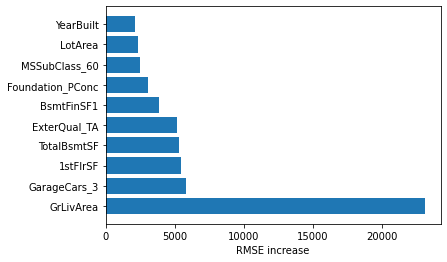

In [40]:
col_nonzero = houseprice.col_names[feature_imp>0]
idx = np.argsort(feature_imp[feature_imp>0])[::-1]
plt.barh(col_nonzero[idx[:10]], width=feature_imp[feature_imp>0][idx[:10]])
plt.xlabel("RMSE increase")
plt.show()

We keep the variables that increases RMSE by more than 0 when they are removed. It turns out that we are left with 48 variables. We can see that when removing feature "GrLiveArea" the RMSE get a lot bigger. "GrLiveArea" is the above grade (ground) living area measured in square feet, it seems to be the most important feature.

In [41]:
%time rf1 = TreeEnsemble(houseprice.xs_train[col_nonzero], houseprice.y_train, n_trees=1, sample_sz=1000, min_leaf=5)

CPU times: user 2.7 s, sys: 55.9 ms, total: 2.75 s
Wall time: 2.76 s


In [42]:
rf2 = RandomForestRegressor(bootstrap=False, max_samples=1000, n_estimators=1, min_samples_leaf=5)
%time rf2.fit(houseprice.xs_train[col_nonzero], houseprice.y_train)

CPU times: user 22 ms, sys: 0 ns, total: 22 ms
Wall time: 26.4 ms


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=1000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [43]:
print_rmse(rf1, rf2, houseprice.xs_valid[col_nonzero], houseprice.xs_train[col_nonzero])

RMSE sklearn: ' 35178.93574501575 ' ' 22055.461232787755 ' 
RMSE TreeEnsemble: ' 23582.57994396016 ' ' 14993.21881169821 '


The model is now simpler since it has less features and it runs much faster. We went from 383 features to 48 without losing accuracy power.

In [44]:
rf = RandomForestRegressor(n_estimators=1, max_depth=3, max_samples=1000, min_samples_leaf=5, bootstrap=False)
rf.fit(houseprice.xs_train[col_nonzero], houseprice.y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=1000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

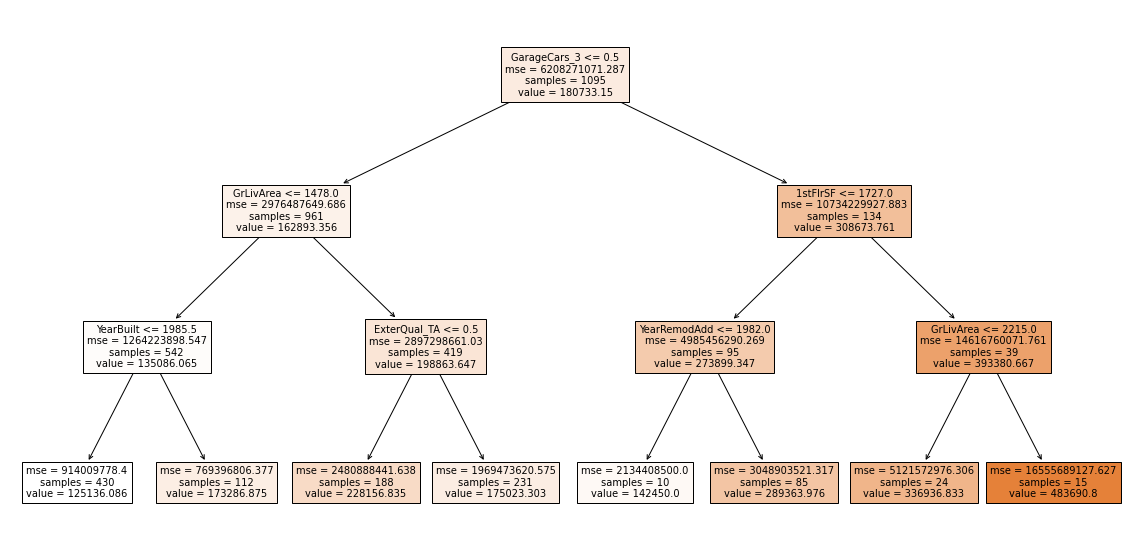

In [45]:
plt.figure(figsize=(20,10))
_ = tree.plot_tree(rf.estimators_[0], feature_names=col_nonzero, filled=True)

The first split is based on "GarageCars_3" and then it splits again on "GrLiveArea". When entering the tree, the algorithm will divide houses in two groups on garage size, houses with garage that has the capacity of more than 3 cars and those which has not. Then it will split again based on living area in square feet for the first group and on first floor area for the other group. It will continue to split until there is only 5 observations on a node, this node is called a leaf node. To get prediction for a specific row, we follow the path until we get to a leaf node then the prediction for the row will be the average sale price in this leaf node.

### Redundant Features

Spearman's rank correlation coefficient assesses how well the relationship between two variables can be described using a monotonic function. We use it here instead Pearson correlation coefficient because it can detect non-linear relationship.

In [46]:
import scipy as scipy
from scipy.cluster import hierarchy as hc
import seaborn as sns
df_keep_float = houseprice.xs[col_nonzero].select_dtypes(include="float")
df_keep_float = df_keep_float.drop("LotFrontage_na", axis=1)
corr = np.round(scipy.stats.spearmanr(df_keep_float).correlation, 4)

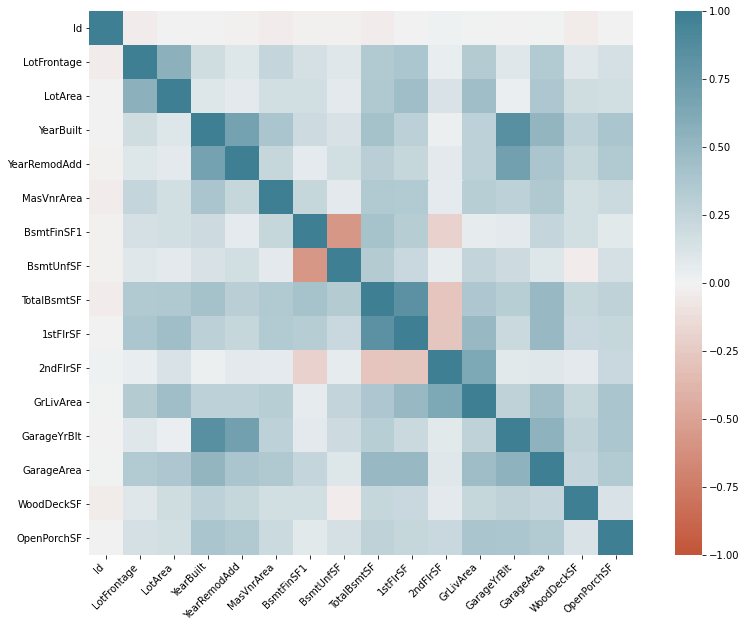

In [47]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels= df_keep_float.columns,
    yticklabels= df_keep_float.columns
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

BsmtFinSF1 is highly correlated with BsmtUnfSF and GrageYrBlt is greatly correlated with YearBuilt, we could remove one of them. We fit 4 model each time without one of those features and check RMSE.

In [48]:
corr_var = ["BsmtFinSF1", "BsmtUnfSF", "GarageYrBlt", "YearBuilt"]
RMSE = []
for c in corr_var:
    corr_copy = list(col_nonzero); corr_copy.remove(c)
    RMSE.append(TreeEnsemble(houseprice.xs_train[corr_copy], houseprice.y_train, n_trees=1, sample_sz=1000, min_leaf=5)
               .score(houseprice.xs_valid[corr_copy], houseprice.y_valid))


In [49]:
RMSE

[24485.778465081345, 23541.866473640523, 23328.82886763922, 23835.638620945272]

It's better to remove "BsmtUnfSF" and "GarageYrBlt" as ignoring them doesn't lead to an increase in RMSE in validation set, in fact it gets lower.

In [50]:
best_col = list(col_nonzero.copy()); best_col.remove("BsmtUnfSF"); best_col.remove("GarageYrBlt")

## Confidence based intervals

In [51]:
%time rf1 = TreeEnsemble(houseprice.xs_train[best_col], houseprice.y_train, n_trees=20, sample_sz=1000, min_leaf=5)

CPU times: user 49.9 s, sys: 1.71 s, total: 51.6 s
Wall time: 51.7 s


We add more trees to the alogrithm and investigate confidence of predictions on the GarageCars feature. 

In [52]:
xs = houseprice.categories
xs["std_pred"] = rf1.confidence_std(houseprice.xs[best_col]); xs["pred"] = rf1.predict(houseprice.xs[best_col]);
xs["SalePrice"] = houseprice.y; xs["std/pred"] = xs["std_pred"]/xs["pred"]

In [53]:
xs[["GarageCars","SalePrice", "pred", "std_pred", "std/pred"]].head(10)

,GarageCars,SalePrice,pred,std_pred,std/pred
0,2,208500,203664.367605,4123.434076,0.020246
1,2,181500,169004.101732,16599.289419,0.098218
2,2,223500,225585.800072,9438.158346,0.041838
3,3,140000,157429.007937,10785.686658,0.068511
4,3,250000,280119.684217,21874.691202,0.078091
5,2,143000,167889.734713,11241.329364,0.066957
6,2,307000,322763.670512,17617.261617,0.054583
7,2,200000,199286.704708,23011.216565,0.115468
8,2,129900,151348.470455,19024.419774,0.125699
9,1,118000,112684.885480,10450.451171,0.092740


We see that sale price predictions are not too far from actual sale price but it's not perfectly accurate. For each row we can see how confident we are at predicting it. "std_pred" is the standard deviation of predictions among trees.

In [54]:
garagecars = xs[["GarageCars","SalePrice", "pred", "std_pred", "std/pred"]].groupby("GarageCars", as_index=False).mean()
garagecars

,GarageCars,SalePrice,pred,std_pred,std/pred
0,0,103317.283951,108656.889644,12178.528139,0.112121
1,1,128116.688347,128319.235864,10520.764903,0.083155
2,2,183851.663835,183624.628073,12440.694084,0.068614
3,3,309636.121547,307683.784489,22261.963689,0.073928
4,4,192655.800000,187490.473663,19389.175065,0.104102


The model gives predictions that are less accurate (relatively speaking as a ratio of total price) for houses having a 4 and 0 car capacity garage. This is because those groups are small as we can see below.

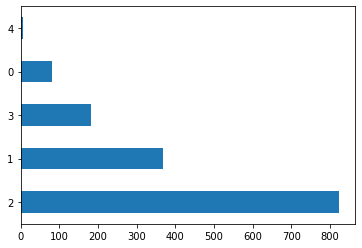

In [55]:
xs.GarageCars.value_counts().plot.barh()
plt.show()

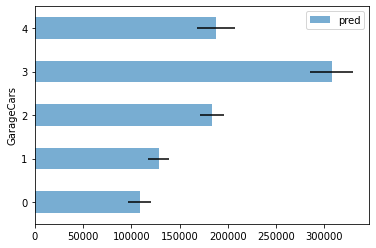

In [56]:
garagecars.plot('GarageCars', 'pred', 'barh', xerr='std_pred', alpha=0.6);

## Partial dependance

Let's plot again feature importance to see if things have changed

In [57]:
feature_imp = rf1.feature_imp()

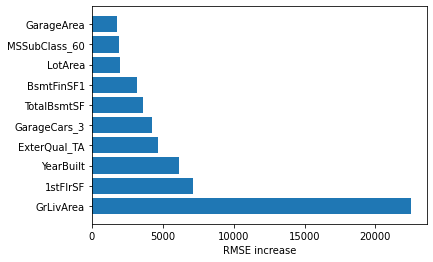

In [58]:
idx = np.argsort(feature_imp)[::-1]
plt.barh(np.array(best_col)[idx[:10]], width=feature_imp[idx[:10]])
plt.xlabel("RMSE increase")
plt.show()

Now "YearBuilt" is on the top 3 most important feature.

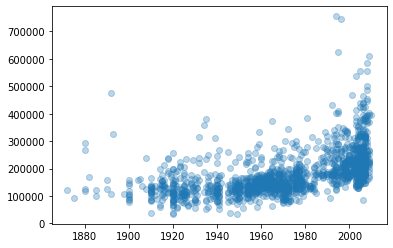

In [59]:
plt.scatter(houseprice.xs["YearBuilt"], houseprice.y, alpha=0.3)
plt.show()

What if we wanted to know what is the relationship between "SalePrice" and "YearBuilt" all other thing being equal. If we sold an house that has the same number of room, the same kitchen quality, the same car capacity garage and so on, would this house cost the same if it were sold in the 90s vs 2010? We can answer using partial dependance. We are going to pick a random subset of our dataset and then fill the "YearBuilt" column by a constant value equal to the earliest year (1872) and we predict the house price. We repeat this for every year until latest year (2010).

In [60]:
yearpred = rf1.partial_dependence("YearBuilt", 500)

In [61]:
yearpred = yearpred.iloc[:, 11:]

We start from the year 1920.

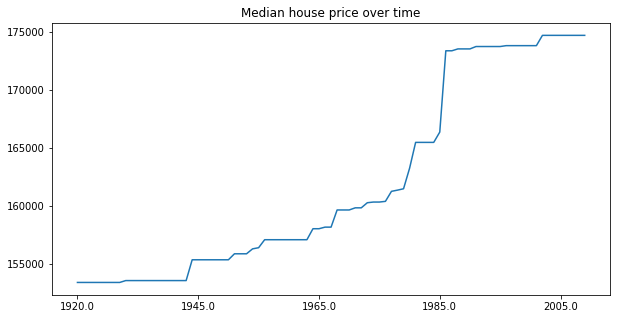

In [62]:
yearpred.median().plot(kind = 'line', legend=False, figsize = (10,5), title = "Median house price over time")
plt.show()

We see a pattern that didn't appear in the univariate plot: median house price increase in a linear fashion until 1980 then there is a huge spike in price, finally few years later it gets back to a linear relationship.

We can plot the trajectory price of some houses to see what it would have cost if it were sold in different years.

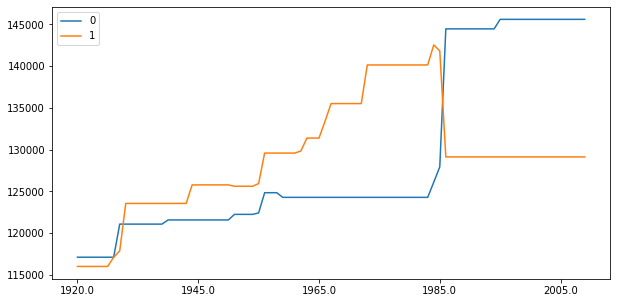

In [63]:
yearpred[:2].T.plot(kind="line", figsize = (10, 5))
plt.show()

# Final model

In [64]:
%time rf1 = TreeEnsemble(houseprice.xs_train[best_col], houseprice.y_train, sample_sz=1000, n_trees = 100, min_leaf=10)

CPU times: user 4min 7s, sys: 4.84 s, total: 4min 11s
Wall time: 4min 12s


In [65]:
rf2 = RandomForestRegressor(n_estimators=100, max_samples=1000, bootstrap=False, min_samples_leaf= 10)
%time rf2.fit(houseprice.xs_train[best_col], houseprice.y_train)

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 1.07 s


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=1000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
print_rmse(rf1, rf2, houseprice.xs_valid[best_col], houseprice.xs_train[best_col])

RMSE sklearn: ' 39253.14650944773 ' ' 28132.72576651877 ' 
RMSE TreeEnsemble: ' 18667.163857370182 ' ' 11731.903165430544 '


A limit of the random forest algorithm is that it can't extrapolate at all but it gives good enough prediction. On average our model predictions are off by about 19000$.